# Set up environment

In [1]:
# !pip install --upgrade folium
# !pip install --upgrade numpy
# !pip install --upgrade pandas
# !pip install --upgrade matplotlib
# !pip install --upgrade seaborn
# !pip install colour
# !pip install --upgrade scikit-learn
# !pip install "tensorflow<2.11"

In [2]:
import datetime

import math

import os

import re

from typing import Dict, Tuple, List

import warnings

In [3]:
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
print(
    f'{sklearn.__version__=}',
    f'{pd.__version__=}',
    f'{tf.__version__=}',
    sep='\n'
)

sklearn.__version__='1.3.0'
pd.__version__='2.0.3'
tf.__version__='2.10.1'


In [5]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [6]:
import ipywidgets as widgets
from ipywidgets import interact

# Preloading

In [7]:
datasets_dir_path = '../data'

## Preloading: preload CSV

In [8]:
csv_datasets_dir_path = os.path.join(
    datasets_dir_path,
    'csv'
)

#### The main air pollution dataset
src: http://201.245.192.252:81/home/map

In [9]:
pollutions_data_file_name = 'RMCAB_air_quality_sensor_data.csv'
pollutions_data_file_path = os.path.join(
    csv_datasets_dir_path,
    pollutions_data_file_name
)

pollutions_data_df = pd.read_csv(
    pollutions_data_file_path
)

#### Stations locations dataset

In [10]:
stations_data_file_name = 'stations_loc.csv'
stations_data_file_path = os.path.join(
    csv_datasets_dir_path,
    stations_data_file_name
)

stations_data_df = pd.read_csv(
    stations_data_file_path
)

# Overview

In [11]:
def overview_df(
    df: pd.DataFrame
) -> None:
    display(
        'df.sample(10):', df.sample(10),
        'df.shape:', df.shape,
        'df.isnull().sum():', df.isnull().sum(),
        'df.dtypes:', df.dtypes
    )

In [12]:
overview_df(pollutions_data_df)

'df.sample(10):'

,PM10,PM2.5,NO,NO2,NOX,CO,OZONO,Station,DateTime
150889,NaN,NaN,3.220,17.430,20.651,0.49086,4.434,USQ,24-03-2021 02:00
150261,6.5,3.1,4.426,7.589,12.014,0.43608,9.907,USQ,25-02-2021 22:00
58973,7.4,6.0,NaN,NaN,NaN,0.39573,25.544,MAM,25-09-2021 06:00
48268,11.6,3.0,5.841,8.519,14.360,0.40126,2.070,PTE,06-07-2021 05:00
10597,17.7,9.6,11.743,21.288,33.031,0.45957,NaN,BOL,18-03-2021 14:00
84410,14.0,14.0,1.851,8.749,10.600,0.26454,5.247,SCR,21-08-2021 03:00
101879,32.9,9.0,4.696,23.208,27.904,0.40741,5.663,JAZ,18-08-2021 24:00
123888,NaN,11.0,4.866,11.175,16.035,NaN,11.040,GYR,22-02-2021 01:00
15073,37.0,18.9,35.493,25.386,60.879,0.56039,0.788,BOL,21-09-2021 02:00
127551,39.0,16.0,1.543,4.420,5.959,0.07706,23.847,GYR,24-07-2021 16:00


'df.shape:'

(166440, 9)

'df.isnull().sum():'

PM10        20014
PM2.5       15312
NO          27664
NO2         27662
NOX         27668
CO          31238
OZONO       32132
Station         0
DateTime        0
dtype: int64

'df.dtypes:'

PM10        float64
PM2.5       float64
NO          float64
NO2         float64
NOX         float64
CO          float64
OZONO       float64
Station      object
DateTime     object
dtype: object

In [13]:
overview_df(stations_data_df)

'df.sample(10):'

,estacion,Sigla,Latitud,Longitud,Altitud (m),Altura (m),Localidad,Tipo de zona,Tipo de estación,Dirección
14,el_jazmin,JAZ,"4°36'30.6""N","74°06'53.8""W",2559,0,Puente Aranda,Urbana,Residencial,Calle 1 G # 41 A 39
13,san_cristobal,SCR,"4°34'21.19""N","74°5'1.73""W",2688,0,San Cristóbal,Urbana,De fondo,Carrera 2 Este # 12-78 sur
19,movil_fontivon,MOV2,"4°40'04.8""N","74°08'54.6""W",2547,0,Fontibón,Urbana,Tráfico/industrial,Cra. 98 #16 B 50
17,ciudad_bolivar,CBV,"4°34'40.1""N","74°09'58.6""W",2661,0,Ciudad Bolívar,Urbana,Residencial,Calle 70 Sur # 56 - 11
3,bolivia,BOL,"4°44'08.9""N","74°07'33.2""W",2574,0,Engativá,Sub urbana,De fondo,Avenida Calle 80 # 121-98
2,suba,SUB,"4°45'40.49""N","74° 5'36.46""W",2571,6,Suba,Sub urbana,De fondo,Carrera 111 # 159A-61
9,pueste_aranda,PTE,"4°37'54.36""N","74°7'2.94""W",2590,10,Puente Aranda,Urbana,Industrial,Calle 10 # 65-28
0,guaymaral,GYR,"4°47'01.5""N","74°02'38.9""W",2580,0,Suba,Sub urbana,De fondo,Autopista Norte # 205-59
12,tunal,TUN,"4°34'34.41""N","74°7'51.44""W",2589,0,Tunjuelito,Urbana,De fondo,Carrera 24 # 49-86 sur
6,movil_7ma,7MA,"4°38'42.7""N","74°03'41.6""W",2583,0,Chapinero,Urbana,De tráfico,Carrera 7 con calle 60


'df.shape:'

(20, 10)

'df.isnull().sum():'

estacion            0
Sigla               0
Latitud             0
Longitud            0
Altitud (m)         0
Altura (m)          0
Localidad           0
Tipo de zona        0
Tipo de estación    0
Dirección           0
dtype: int64

'df.dtypes:'

estacion            object
Sigla               object
Latitud             object
Longitud            object
Altitud (m)          int64
Altura (m)           int64
Localidad           object
Tipo de zona        object
Tipo de estación    object
Dirección           object
dtype: object

# Preprocessing

## Preprocessing: fix datetime

In [14]:
pollutions_data_df['DateTime'] = pollutions_data_df['DateTime'].str.replace(
    ' 24:',
    ' 00:'
)

In [15]:
pollutions_data_df['DateTime'] = pd.to_datetime(
    pollutions_data_df['DateTime'],
    format='%d-%m-%Y %H:%M'
)

## Preprocessing: fix longt/lat

In [16]:
def parse_dms(
    coordinates: str
) -> float:
    parts = re.split('[^\d\w]+', coordinates)
    degrees = float(parts[0])
    minutes = float(parts[1])
    seconds = float(parts[2] + '.' + parts[3])
    direction = parts[4]
    
    dec_coord = degrees + minutes / 60 + seconds / (3600)
    
    if direction == 'S' or direction == 'W':
        dec_coord *= -1
    
    return dec_coord

In [17]:
stations_data_df['Latitud'] = stations_data_df['Latitud'].apply(parse_dms)

stations_data_df['Longitud'] = stations_data_df['Longitud'].apply(parse_dms)

## Preprocessing: merge datasets together

In [18]:
air_data_df = pd.merge(
    left=pollutions_data_df, right=stations_data_df,
    how='inner',
    left_on='Station', right_on='Sigla'
)

## Preprocessing: reorder values

In [19]:
air_data_df = air_data_df.sort_values(by='DateTime')

# Analysis

In [20]:
pollutants_list = ['PM2.5', 'PM10',  'NO', 'NO2', 'NOX', 'CO', 'OZONO']

In [21]:
FONT_SIZE_TICKS = 12
FONT_SIZE_TITLE = 20
FONT_SIZE_AXES = 16

## Analysis: visualize missing data points

In [22]:
def display_missing_values_on_time_series(
    df: pd.DataFrame
) -> None:
    def _interactive_time_series_plot(
        station: str,
        date_range: Tuple[datetime.date],
        target: str
    ) -> None:
        plt.figure(figsize=(15,6))
        data = df[
            (df['Station'] == station) &
            (df['DateTime'] >= date_range[0]) &
            (df['DateTime'] <= date_range[1])
        ]
        # time series data
        plt.plot(data["DateTime"], data[target], '-')
        # missing values data
        target_is_null_filter = data[target].isnull()
        ax = plt.gca()
        for x_value in data.loc[target_is_null_filter, 'DateTime']:
            ax.axvline(x=x_value, color='red', linestyle='-')
        # plot params
        plt.title(f'Change of {target}', fontsize=FONT_SIZE_TITLE)
        plt.ylabel(f'{target} concentration', fontsize=FONT_SIZE_AXES)
        plt.xticks(rotation=20, fontsize=FONT_SIZE_TICKS)
        plt.yticks(fontsize=FONT_SIZE_TICKS)
        plt.show()
    
    # Widget for picking the station
    station_widget = widgets.Dropdown(
        options=df.Station.unique(),
        description='Station'
    )
    
    # Widget for picking pollutant
    pollutant_widget = widgets.Dropdown(
        options=pollutants_list,
        description='Pollutant'
    )
    
    # Widget for selecting DateTime date range
    dates = pd.date_range(
        df['DateTime'].min().date(),
        df['DateTime'].max().date(),
        freq='D'
    )
    options = [(date.strftime(' %d/%m/%Y '), date) for date in dates]
    index = (0, len(options)-1)
    date_range_widget = widgets.SelectionRangeSlider(
        options=options,
        index=index,
        description='Dates',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    # Display widget
    interact(
        _interactive_time_series_plot,
        station=station_widget,
        date_range=date_range_widget,
        target=pollutant_widget
    )

In [23]:
display_missing_values_on_time_series(
    air_data_df
)

interactive(children=(Dropdown(description='Station', options=('SCR', 'MAM', 'LFR', 'KEN', 'SUB', 'USQ', 'USM'…

## Analysis: size of gaps

In [24]:
def display_gaps_distribution(df: pd.core.frame.DataFrame, target: str):
    '''Plots the distribution of the gap sizes in the dataframe
    
    Args:
        df (pd.core.frame.DataFrame): The dataframe
        target (str): The chosen pollutant for which it plots the distribution
    '''
    def get_size_down_periods(df, target):
        '''Get the size of the downtime periods for the sensor'''
        distribution = [0] * 4000
        x = []
        i = -1
        total_missing = 0
        count = 0
        for row in df[target].values:
            if math.isnan(row):
                total_missing += 1
                if i == 0:
                    count = 1
                    i = 1
                else:
                    count += 1
            else:
                try:
                    if count > 0:
                        distribution[count] += 1 
                        x.append(count)
                except:
                    print(count)
                i = 0
                count = 0

        distribution[0] = df[target].shape[0] - total_missing

        return distribution

    distribution = get_size_down_periods(df, target=target)
    for i in range(len(distribution)):
        distribution[i] = distribution[i]*i
    only_missing_per = distribution[1:-1]
    
    plt.figure(figsize=(10,6))
    plt.plot(only_missing_per)
    plt.xlabel('Gap size (Hours)', fontsize=FONT_SIZE_AXES)
    plt.ylabel('Number of missing data points', fontsize=FONT_SIZE_AXES)
    plt.title('Distribution of gaps in the data', fontsize=FONT_SIZE_TITLE)
    plt.xticks(fontsize=FONT_SIZE_TICKS)
    plt.yticks(fontsize=FONT_SIZE_TICKS)
    plt.show()

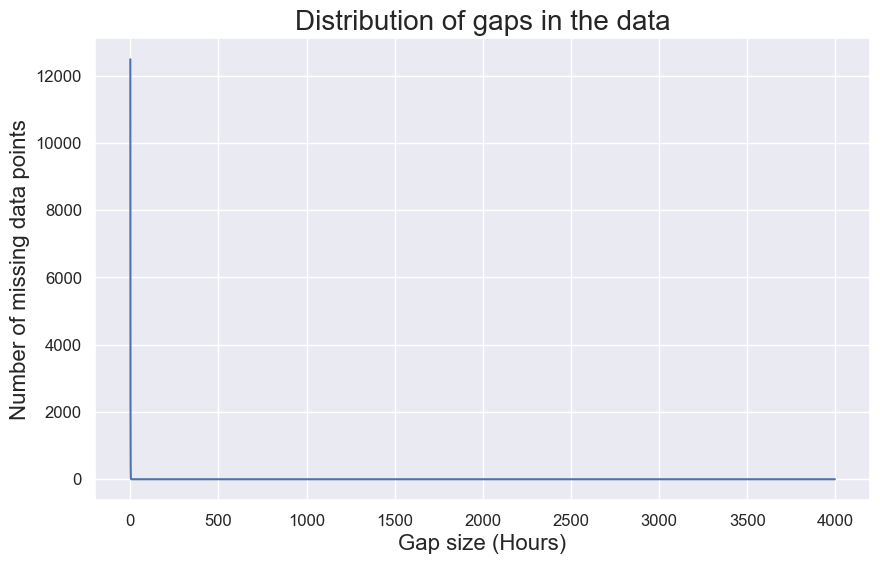

In [25]:
display_gaps_distribution(
    air_data_df,
    target='PM2.5'
)

## Visualize Last value impute & Nearest neighbor impute

In [26]:
def visualize_missing_values_estimation(df: pd.core.frame.DataFrame, day: datetime):
    '''Visualizes two ways of interpolating the data: nearest neighbor and last value
    and compares them to the real data
    
    Args:
        df (pd.core.frame.DataFrame): The dataframe
        day (datetime): The chosen day to plot
    '''
    day = day.date()

    # Filter out the data for the day for the USM station
    rows_of_day = df.apply(lambda row : row['DateTime'].date() == day, axis=1)
    sample = df[rows_of_day]
    
    def draw(sample, station, missing_index, target):
        sample = sample.copy()
        sample.insert(
            0,
            'time_discriminator', 
            (sample['DateTime'].dt.dayofyear * 100000 + sample['DateTime'].dt.hour * 100).values,
            True
        )

        real = sample[sample['Station'] == station]
        example1 = real.copy()
        real = real.reset_index()
        example1 = example1.reset_index()
        example1.loc[missing_index, target] = float('NaN')

        missing = missing_index
        missing_before_after = [missing[0]-1] + missing + [missing[-1] + 1]
        dates = set(list(example1.loc[missing_index,'DateTime'].astype(str)))

        plt.figure(figsize=(10, 5))
        plt.plot(missing_before_after, real.loc[missing_before_after][target] , 'r--o', label='actual values')

        sample_copy = sample.copy()
        sample_copy = sample_copy.reset_index()
        to_nan = sample_copy.apply(lambda row : str(row['DateTime']) in dates and row['Station'] == station, axis=1)
        sample_copy.loc[to_nan, target] = float('NaN')
        imputer = KNNImputer(n_neighbors=1)
        imputer.fit(sample_copy[['time_discriminator','Latitud', 'Longitud', target]])
        example1[f'new{target}'] = imputer.transform(example1[['time_discriminator', 'Latitud', 'Longitud', target]])[:,3]
        plt.plot(missing_before_after, example1.loc[missing_before_after][f'new{target}'], 'g--o', label='nearest neighbor')

        plt.plot(example1.index, example1[target], '-*')

        example1[f'ffill{target}'] = example1.fillna(method='ffill')[target]
        plt.plot(missing_before_after, example1.loc[missing_before_after][f'ffill{target}'], 'y--*', label='last known value')

        plt.xlabel('Hour of day', fontsize=FONT_SIZE_AXES)
        plt.ylabel(f'{target} concentration', fontsize=FONT_SIZE_AXES)
        plt.title('Estimating missing values', fontsize=FONT_SIZE_TITLE)
        plt.legend(loc="upper left", fontsize=FONT_SIZE_TICKS)
        plt.xticks(fontsize=FONT_SIZE_TICKS)
        plt.yticks(fontsize=FONT_SIZE_TICKS)
        plt.show()
    
    def selector(station, hour_start, window_size, target):
        missing_index_list = list(range(hour_start, hour_start+window_size)) 
        draw(
            sample=sample,
            station=station,
            missing_index=missing_index_list,
            target=target
        )
    
    # Widgets for selecting the parameters
    station_selection = widgets.Dropdown(
        options=df.Station.unique(),
        description='Station',
        value='USM'
    )
    target_pollutant_selection = widgets.Dropdown(
        options=pollutants_list,
        description='Pollutant',
        value='PM2.5'
    )
    hour_start_selection = widgets.Dropdown(
        options=list([2, 3, 4, 5, 6, 7, 8, 9, 10]),
        description='Hour start',
        value=3
    )
    window_size_selection = widgets.Dropdown(
        options=list([1, 2, 3, 5, 6, 9, 12]),
        description='Window size',
        value=1
    )
    
    return interact(
        selector,
        station=station_selection,
        hour_start=hour_start_selection,
        window_size=window_size_selection,
        target=target_pollutant_selection
    )

In [27]:
# Specify the date to plot
day = datetime.datetime(2021, 5, 6)

# Create a plot to display the linear interpolation for a range of hours
visualize_missing_values_estimation(air_data_df, day)

interactive(children=(Dropdown(description='Station', index=6, options=('SCR', 'MAM', 'LFR', 'KEN', 'SUB', 'US…

<function __main__.visualize_missing_values_estimation.<locals>.selector(station, hour_start, window_size, target)>

# Modeling

## Modeling: establish a baseline

In [28]:
def calculate_mae_for_nearest_station(df: pd.core.frame.DataFrame, target: str) -> Dict[str, float]:
    '''Create a nearest neighbor model and run it on your test data
    
    Args:
        df (pd.core.frame.DataFrame): The dataframe
        target (str): The chosen pollutant for which it plots the distribution
    '''
    df2 = df.dropna(inplace=False)
    df2.insert(0, 'time_discriminator', (df2['DateTime'].dt.dayofyear * 100000 + df2['DateTime'].dt.hour * 100).values, True)

    train_df, test_df = train_test_split(df2, test_size=0.2, random_state=57)

    imputer = KNNImputer(n_neighbors=1)
    imputer.fit(train_df[['time_discriminator','Latitud', 'Longitud', target]])

    regression_scores = {}

    y_test = test_df[target].values

    test_df2 = test_df.copy()
    test_df2.loc[test_df.index, target] = float("NAN")

    y_pred = imputer.transform(test_df2[['time_discriminator', 'Latitud', 'Longitud', target]])[:,3]
    
    return {"MAE": mean_absolute_error(y_pred, y_test)}

In [29]:
# Create a nearest neighbor model and run it on your test data
regression_scores = {}
regression_scores['baseline_model'] = calculate_mae_for_nearest_station(air_data_df, target='PM2.5')
print(regression_scores['baseline_model'])

{'MAE': 7.867988869489306}


## Modeling: NN with x2 relu

In [30]:
# Define the variable you want to predict
target = 'PM2.5'

# Create new columns for day of week and hour of day
raw_data_for_imputing = air_data_df.copy()
raw_data_for_imputing['day_week'] = pd.DatetimeIndex(raw_data_for_imputing['DateTime']).weekday
raw_data_for_imputing['hour'] = pd.DatetimeIndex(raw_data_for_imputing['DateTime']).hour

# Create a numerical representation of station ID and add as extra columns to the dataframe
one_hot = pd.get_dummies(raw_data_for_imputing.Station, prefix='Station')
raw_data_for_imputing = raw_data_for_imputing.join(one_hot)

# Make a copy of the dataframe before dropping rows with missing values
data_no_missing = raw_data_for_imputing.copy()  
# Drop all rows containing missing values
data_no_missing.dropna(inplace=True)
# Print out the number of missing values in the PM2.5 column as a check (should print 0)
null_remaining = data_no_missing[target].isnull().sum()
if null_remaining == 0: 
    print('missing values removed and data prepared successfully!')

missing values removed and data prepared successfully!


In [31]:
train_data, test_data = train_test_split(data_no_missing, test_size=0.20, random_state=57)

print(f'Train dataset size: {train_data.shape}')
print(f'Test dataset size: {test_data.shape}')

Train dataset size: (73309, 40)
Test dataset size: (18328, 40)


In [32]:
# Define the features you will base your predictions on 
pollutants_list = ['PM10','PM2.5','NO','NO2','NOX','CO','OZONO']
pollutants_except_target = [i for i in pollutants_list if i != target]
feature_names = ['day_week', 'hour'] + list(one_hot.columns) + pollutants_except_target

In [33]:
def build_keras_model(input_size: int) -> tf.keras.Model:
    '''Build a neural network with three fully connected layers (sizes: 64, 32, 1)
    
    Args:
        input_size (int): The size of the input
        
    Returns:
        model (tf.keras.Model): The neural network
    '''
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[input_size]),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
      ])

    optimizer = tf.keras.optimizers.RMSprop(0.007)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    
    return model

###

# Define the neural network model architecture
model = build_keras_model(input_size=len(feature_names))

In [34]:
def train_and_test_model(
    feature_names: List[str],
    target: str,
    train_df: pd.core.frame.DataFrame,
    test_df: pd.core.frame.DataFrame,
    model: tf.keras.Model,
    number_epochs: int=5
) -> Tuple[tf.keras.Model, StandardScaler, Dict[str, float]]:
    '''
    This function will take the features (x), the target (y) and the model and will fit
    and Evaluate the model.
    
    Args:
        feature_names (List[str]): Names of feature columns
        target (str): Name of the target column
        train_df (pd.core.frame.DataFrame): Dataframe with training data
        test_df (pd.core.frame.DataFrame): Dataframe with test data
        model (tf.keras.Model): Model to be fit to the data
        number_epochs (int): Number of epochs
    
    Returns:
        model (tf.keras.Model): Fitted model
        scaler (StandardScaler): scaler
        MAE (Dict[str, float]): Dictionary containing mean absolute error.
    '''
    scaler = StandardScaler()
    
    X_train = train_df[feature_names]
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    y_train = train_df[target]
    X_test = test_df[feature_names]
    X_test = scaler.transform(X_test)
    y_test = test_df[target]

    # Build and train model
    model.fit(X_train, y_train, batch_size=64, epochs=number_epochs)
    y_pred = model.predict(X_test)
    #print(f"\nModel Score: {model.score(X_test, y_test)}")
    MAE = {"MAE": mean_absolute_error(y_pred, y_test)}
    return model, scaler, MAE

###

# Train and test the model
model, scaler, mae = train_and_test_model(feature_names, target, train_data, test_data, model, number_epochs=10)
regression_scores['neural_network_model'] = mae

Epoch 1/10
1146/1146 [==============================] - 2s 1ms/step - loss: 39.5881 - mae: 4.5798
Epoch 2/10
1146/1146 [==============================] - 2s 1ms/step - loss: 35.5005 - mae: 4.3522
Epoch 3/10
1146/1146 [==============================] - 1s 1ms/step - loss: 34.1645 - mae: 4.2635
Epoch 4/10
1146/1146 [==============================] - 1s 1ms/step - loss: 33.4179 - mae: 4.2188
Epoch 5/10
1146/1146 [==============================] - 1s 1ms/step - loss: 32.9456 - mae: 4.1921
Epoch 6/10
1146/1146 [==============================] - 2s 1ms/step - loss: 32.5605 - mae: 4.1611
Epoch 7/10
1146/1146 [==============================] - 2s 1ms/step - loss: 32.1764 - mae: 4.1325
Epoch 8/10
1146/1146 [==============================] - 2s 1ms/step - loss: 31.9346 - mae: 4.1205
Epoch 9/10
1146/1146 [==============================] - 2s 1ms/step - loss: 31.6148 - mae: 4.1063
Epoch 10/10
573/573 [==============================] - 1s 935us/step


In [35]:
# Print out the MAE result
for model_name, model_score in regression_scores.items():
    print(model_name, ' : ', model_score)

baseline_model  :  {'MAE': 7.867988869489306}
neural_network_model  :  {'MAE': 4.11056556497818}


# Finalization

## Finalization: Apply models to estimate measurements

In [36]:
def impute_nontarget_missing_values_interpolate(
    df_with_missing: pd.core.frame.DataFrame,
    feature_names: List[str],
    target: str,
) -> pd.core.frame.DataFrame:
    '''
    Imputes data to non-target variables using interpolation.
    This data can then be used by NN to impute the target column.
    
    Args:
        df_with_missing (pd.core.frame.DataFrame): The dataframe with the data.
        feature_names (List[str]): Names of feature columns
        target (str): Name of the target column
        
    Returns:
        imputed_values_with_flag (pd.core.frame.DataFrame): The dataframe with imputed values and flags.
    '''
    pollutants_except_target = [i for i in pollutants_list if i != target]
    
    # Flag the data that was imputed
    imputed_flag = df_with_missing[pollutants_except_target]

    warnings.filterwarnings('ignore')
    
    for pollutant in pollutants_except_target:
        # Create the flag column for the pollutant
        imputed_flag[f'{pollutant}_imputed_flag'] = np.where(imputed_flag[pollutant].isnull(), 'interpolated', None)
        imputed_flag.drop(pollutant, axis=1, inplace=True)
        
        # Impute a value to the first one if it is missing, because interpolate does not fix the first value
        if np.any(df_with_missing.loc[[df_with_missing.index[0]], [pollutant]].isnull()):
            df_with_missing.loc[[df_with_missing.index[0]], [pollutant]] = [12]
    
    # Interpolate missing values
    imputed_values = df_with_missing[feature_names].interpolate(method='linear')
    
    imputed_values_with_flag = imputed_values.join(imputed_flag)
    
    return imputed_values_with_flag

In [37]:
def impute_target_missing_values_neural_network(
    df_with_missing: pd.core.frame.DataFrame,
    model: tf.keras.Model,
    scaler: StandardScaler,
    baseline_imputed: pd.core.frame.DataFrame,
    target: str,
) -> pd.core.frame.DataFrame:
    '''
    Imputes data to non-target variables using interpolation.
    This data can then be used by NN to impute the target column.
    
    Args:
        df_with_missing (pd.core.frame.DataFrame): The dataframe with the data.
        model (tf.keras.Model): Model
        scaler (StandardScaler): scaler
        baseline_imputed (pd.core.frame.DataFrame): The dataframe with imputed values and flags for nontarget.
        target (str): Name of the target column
        
    Returns:
        data_with_imputed (pd.core.frame.DataFrame): The dataframe with imputed values and flags.
    '''
    # Metadata columns that we want to output in the end
    metadata_columns = ['DateTime', 'Station', 'Latitud', 'Longitud']
    
    # Save the data and imputed flags of nontarget pollutant for outputting later
    baseline_imputed_data_and_flags = baseline_imputed[
        [
            i
            for i in list(baseline_imputed.columns)
            if i in pollutants_list
            or 'flag' in i
        ]
    ]
    
    # Flag the data that will be imputed with NN
    imputed_flag = df_with_missing[[target]]
    imputed_flag[f'{target}_imputed_flag'] = np.where(imputed_flag[target].isnull(), 'neural network', None)
    imputed_flag.drop(target, axis=1, inplace=True)
    
    # For predicting drop the flags, because the neural network doesnt take them
    baseline_imputed = baseline_imputed[[i for i in list(baseline_imputed.columns) if 'flag' not in i]]
    # For predicting we just need the rows where the target pollutant is actually missing
    baseline_imputed = baseline_imputed[df_with_missing[target].isnull()]

    # Predict the target
    baseline_imputed = scaler.transform(baseline_imputed)
    predicted_target = model.predict(baseline_imputed)
    
    # Replace the missing values in the original dataframe with predicted ones
    index_of_missing = df_with_missing[target].isnull()
    data_with_imputed = df_with_missing.copy()
    data_with_imputed.loc[index_of_missing, target] = predicted_target
    
    # Add the flag to the predicted values
    data_with_imputed = data_with_imputed[
        metadata_columns + [target]
    ].join(imputed_flag).join(baseline_imputed_data_and_flags)
    
    # Rearrange the columns so they are in a nicer order for visual representation
    order_of_columns = metadata_columns + pollutants_list + [i + '_imputed_flag' for i in pollutants_list]
    data_with_imputed = data_with_imputed[order_of_columns]
    
    return data_with_imputed

In [38]:
# Estimate non-PM2.5 missing values with the nearest neighbor method
imputed_with_baseline_model = impute_nontarget_missing_values_interpolate(
    raw_data_for_imputing,
    feature_names,
    target
)

# Estimate missing PM2.5 values with 
data_with_imputed = impute_target_missing_values_neural_network(
    raw_data_for_imputing,
    model,
    scaler,
    imputed_with_baseline_model,
    target
)

479/479 [==============================] - 1s 1ms/step


In [39]:
# Print out a count of missing data for each column in the dataset with imputed values
data_with_imputed[pollutants_list].isnull().sum()

PM10     0
PM2.5    0
NO       0
NO2      0
NOX      0
CO       0
OZONO    0
dtype: int64

In [40]:
# Print out a sample of the dataframe
display(
    data_with_imputed.sample(25)
)

,DateTime,Station,Latitud,Longitud,PM10,PM2.5,NO,NO2,NOX,CO,OZONO,PM10_imputed_flag,PM2.5_imputed_flag,NO_imputed_flag,NO2_imputed_flag,NOX_imputed_flag,CO_imputed_flag,OZONO_imputed_flag
63830,2021-04-15 15:00:00,CBV,4.577806,-74.166278,5.900000,5.900000,0.7160,2.5020,3.2190,0.057190,17.4430,None,None,None,None,None,None,None
90806,2021-05-14 15:00:00,FTB,4.678242,-74.143819,23.933333,10.319853,3.6000,9.0340,12.6335,0.243250,15.6640,interpolated,neural network,interpolated,interpolated,interpolated,interpolated,interpolated
33619,2021-11-02 20:00:00,TUN,4.576225,-74.130956,86.000000,33.000000,26.4350,25.0090,51.4400,1.586630,7.2040,None,None,None,None,None,None,None
160062,2021-04-10 07:00:00,KEN,4.625050,-74.161333,61.300000,36.000000,77.7710,20.9070,98.6780,1.804050,6.1390,None,None,None,None,None,None,None
130770,2021-12-05 19:00:00,GYR,4.783750,-74.044139,25.000000,1.000000,41.1440,14.1410,55.3100,0.881950,4.1915,None,None,None,None,None,None,interpolated
133986,2021-04-18 19:00:00,COL,4.737194,-74.069472,10.300000,0.500000,0.3470,5.7580,6.1050,0.353600,12.2040,None,None,None,None,None,None,interpolated
69271,2021-11-28 08:00:00,CBV,4.577806,-74.166278,70.000000,26.000000,26.2400,20.8960,47.1360,0.933670,10.5710,None,None,None,None,None,None,None
49158,2021-08-12 07:00:00,PTE,4.631767,-74.117483,41.900000,33.000000,86.3960,26.4100,112.8060,1.404660,1.0170,None,None,None,None,None,None,None
80561,2021-03-13 18:00:00,SCR,4.572553,-74.083814,38.000000,16.000000,3.9800,27.6170,31.5960,0.440855,12.5190,None,None,None,None,None,interpolated,None
26621,2021-01-15 06:00:00,TUN,4.576225,-74.130956,34.000000,16.000000,46.8360,21.4610,68.2950,0.781940,1.9070,None,None,None,None,None,None,None


## Finalization: save results

In [41]:
data_with_imputed.to_csv('results/full_data_with_imputed_values.csv')

In [42]:
print(datetime.datetime.now())

2023-07-08 23:51:27.040480
